1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?	CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?	각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?	기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [3]:
!pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 11.9 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21501 sha256=c1b56acfe7126823d6a8b29a90a1f28e49365aa15655fd3efebbca043ea51e44
  Stored in directory: /root/.cache/pip/wheels/90/74/b1/9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise
  Attempting uninst

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


2023-12-29 10:12:10.024680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 10:12:10.342091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 10:12:10.342136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 10:12:10.392337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 10:12:10.498376: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

2023-12-29 10:12:13.802431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 10:12:13.875906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 10:12:13.879446: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [4]:
image_size_x =224
image_size_y = 224

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)

    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):

    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix and not with_mixup:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup and not with_cutmix:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)
ds_train_no_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_no_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


In [15]:
def show_dataset_samples(dataset, info, num_samples=5):
    """
    시각화할 데이터셋의 샘플 이미지를 출력하는 함수입니다.

    Parameters:
    dataset (tf.data.Dataset): 시각화할 TensorFlow 데이터셋
    info (tfds.core.DatasetInfo): 데이터셋에 대한 정보 객체
    num_samples (int): 시각화할 샘플의 수 (기본값: 5)
    """
    # 데이터셋에서 샘플을 추출
    for i, example in enumerate(dataset.take(num_samples)):
        # 이미지와 레이블 추출
        image = example["image"]
        label = example["label"]

        # 이미지 시각화
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(info.features["label"].int2str(label))
        plt.axis('off')

    plt.show()

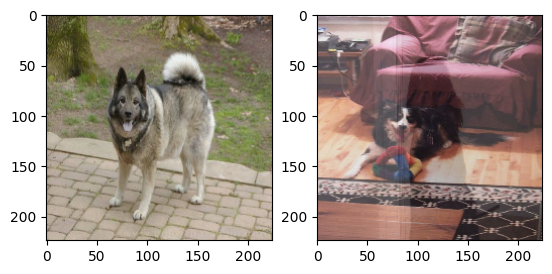

In [10]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug_mixup.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

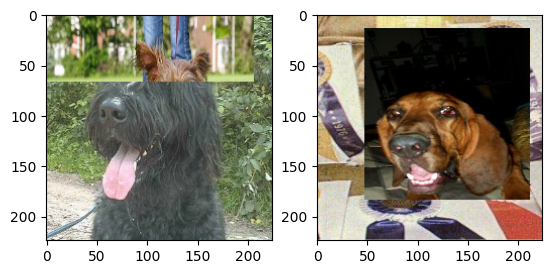

In [11]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug_cutmix.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()


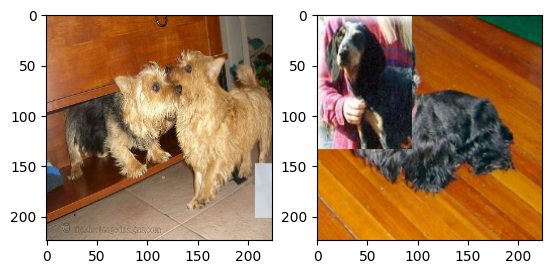

In [11]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug_cutmix.take(1)):
    if i == 0:
        image_a = image[2]
        image_b = image[3]
        label_a = label[2]
        label_b = label[3]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()


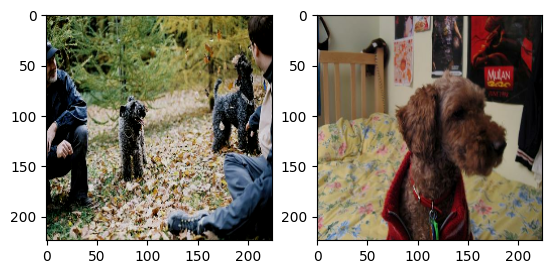

In [12]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()


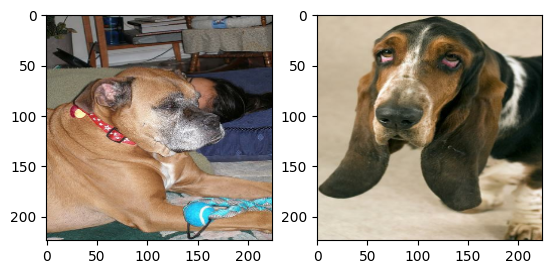

In [13]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a2 = image[0]
        image_b2 = image[1]
        label_a2 = label[0]
        label_b2 = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a2)

plt.subplot(1,2,2)
plt.imshow(image_b2)

plt.show()

In [29]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
# 체크포인트 콜백 설정
checkpoint_path = "resnet50_checkpoint.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max',
    verbose=1
)
log_dir = os.path.join("logs", "fit", "resnet50")
# TensorBoard 콜백
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
     callbacks=[checkpoint,tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2386 - accuracy: 0.4437
Epoch 1: val_accuracy improved from -inf to 0.18703, saving model to resnet50_checkpoint.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 106s 124ms/step - loss: 2.2386 - accuracy: 0.4437 - val_loss: 3.5140 - val_accuracy: 0.1870
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 0.7827 - accuracy: 0.7818
Epoch 2: val_accuracy improved from 0.18703 to 0.67351, saving model to resnet50_checkpoint.h5
750/750 [==============================] - 92s 123ms/step - loss: 0.7827 - accuracy: 0.7818 - val_loss: 1.1089 - val_accuracy: 0.6735
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.9267
Epoch 3: val_accuracy improved from 0.67351 to 0.71514, saving model to resnet50_checkpoint.h5
750/750 [==============================] - 92s 123ms/step - loss: 0.3115 - accuracy: 0.9267 - val_loss: 0.9774 - val_accuracy: 0.7151
Epoch 4/20
750/750 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9862
Epoch 4: val_accuracy improved from 0.71514 to 0.72353, saving model to resnet50_checkpoint.h5
750/750 [===============

In [20]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [21]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
# 체크포인트 콜백 설정
checkpoint_path = "aug_resnet50.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max',
    verbose=1
)
log_dir = os.path.join("logs", "fit", "aug_resnet50")
# TensorBoard 콜백
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint,tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 2.2752 - accuracy: 0.4315
Epoch 1: val_accuracy improved from -inf to 0.27822, saving model to aug_resnet50.h5
750/750 [==============================] - 106s 123ms/step - loss: 2.2752 - accuracy: 0.4315 - val_loss: 2.9204 - val_accuracy: 0.2782
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 1.0027 - accuracy: 0.7132
Epoch 2: val_accuracy improved from 0.27822 to 0.66511, saving model to aug_resnet50.h5
750/750 [==============================] - 92s 123ms/step - loss: 1.0027 - accuracy: 0.7132 - val_loss: 1.1662 - val_accuracy: 0.6651
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.8317
Epoch 3: val_accuracy did not improve from 0.66511
750/750 [==============================] - 91s 122ms/step - loss: 0.5949 - accuracy: 0.8317 - val_loss: 1.1729 - val_accuracy: 0.6643
Epoch 4/20
750/750 [==============================] - ETA: 0s - loss: 0.3394 - accura

In [22]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# 체크포인트 콜백 설정
checkpoint_path = "mix_resnet50.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max',
    verbose=1
)

mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mix = mix_resnet50.fit(
    ds_train_no_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint,tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 3.7491 - accuracy: 0.2312
Epoch 1: val_accuracy improved from -inf to 0.11497, saving model to mix_resnet50.h5
750/750 [==============================] - 108s 126ms/step - loss: 3.7491 - accuracy: 0.2312 - val_loss: 4.1183 - val_accuracy: 0.1150
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 2.8682 - accuracy: 0.4703
Epoch 2: val_accuracy improved from 0.11497 to 0.54618, saving model to mix_resnet50.h5
750/750 [==============================] - 94s 126ms/step - loss: 2.8682 - accuracy: 0.4703 - val_loss: 1.6425 - val_accuracy: 0.5462
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 2.6150 - accuracy: 0.5676
Epoch 3: val_accuracy improved from 0.54618 to 0.61381, saving model to mix_resnet50.h5
750/750 [==============================] - 95s 126ms/step - loss: 2.6150 - accuracy: 0.5676 - val_loss: 1.3588 - val_accuracy: 0.6138
Epoch 4/20
750/750 [============================

In [23]:
cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# 체크포인트 콜백 설정
checkpoint_path = "cut_resnet50.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max',
    verbose=1
)
log_dir = os.path.join("logs", "fit", "cut_resnet50")
# TensorBoard 콜백
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
cut_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cut = cut_resnet50.fit(
    ds_train_no_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint,tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 3.8169 - accuracy: 0.2153
Epoch 1: val_accuracy improved from -inf to 0.22330, saving model to cut_resnet50.h5
750/750 [==============================] - 107s 125ms/step - loss: 3.8169 - accuracy: 0.2153 - val_loss: 3.2435 - val_accuracy: 0.2233
Epoch 2/20
750/750 [==============================] - ETA: 0s - loss: 2.9290 - accuracy: 0.4323
Epoch 2: val_accuracy improved from 0.22330 to 0.61695, saving model to cut_resnet50.h5
750/750 [==============================] - 93s 125ms/step - loss: 2.9290 - accuracy: 0.4323 - val_loss: 1.3881 - val_accuracy: 0.6170
Epoch 3/20
750/750 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.5327
Epoch 3: val_accuracy did not improve from 0.61695
750/750 [==============================] - 93s 124ms/step - loss: 2.6377 - accuracy: 0.5327 - val_loss: 1.4174 - val_accuracy: 0.6098
Epoch 4/20
750/750 [==============================] - ETA: 0s - loss: 2.4179 - accura

In [24]:
!pip install aiffel7


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [25]:
from aiffel7 import history_graph


# 레즈넷 50

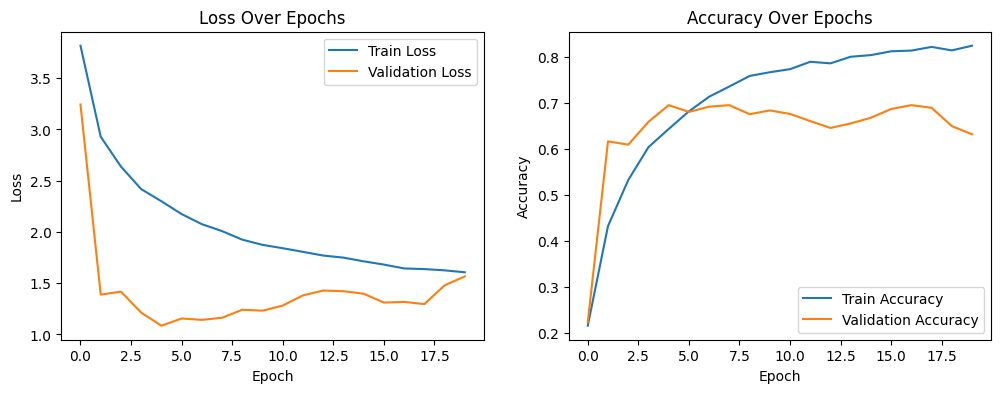

In [32]:
history_graph.plot_history(history_resnet50_cut)


# MIX

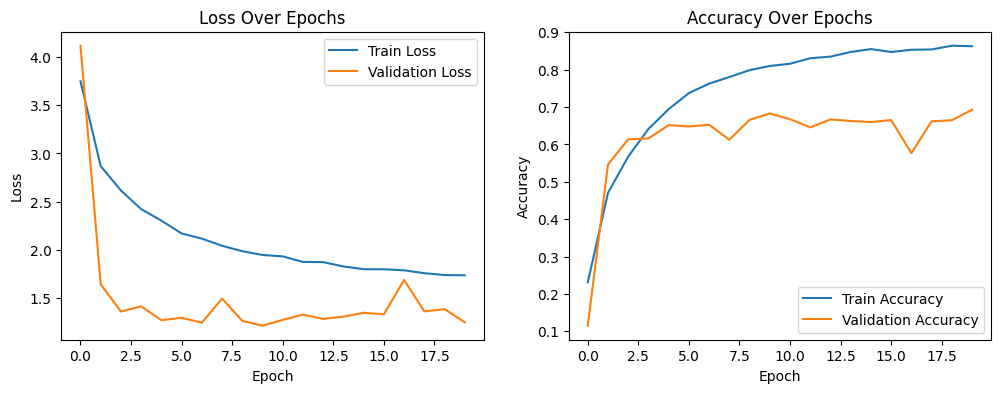

In [33]:
history_graph.plot_history(history_resnet50_mix)


# AUG

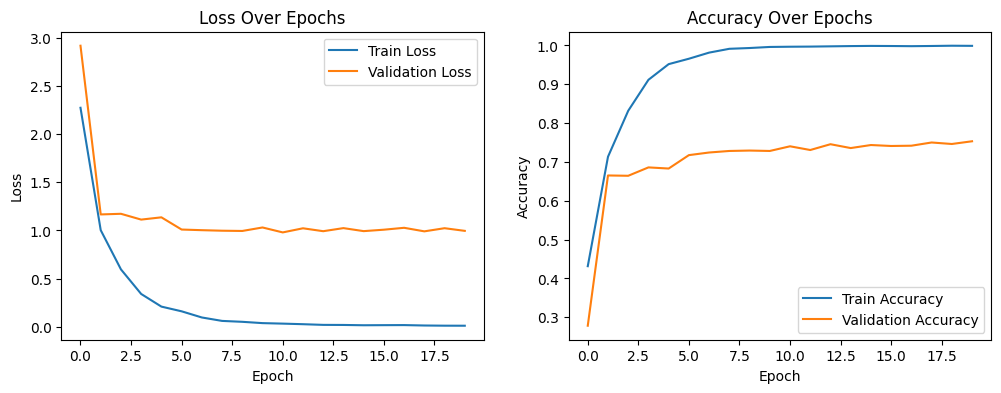

In [34]:
history_graph.plot_history(history_resnet50_aug)

# no_Aug

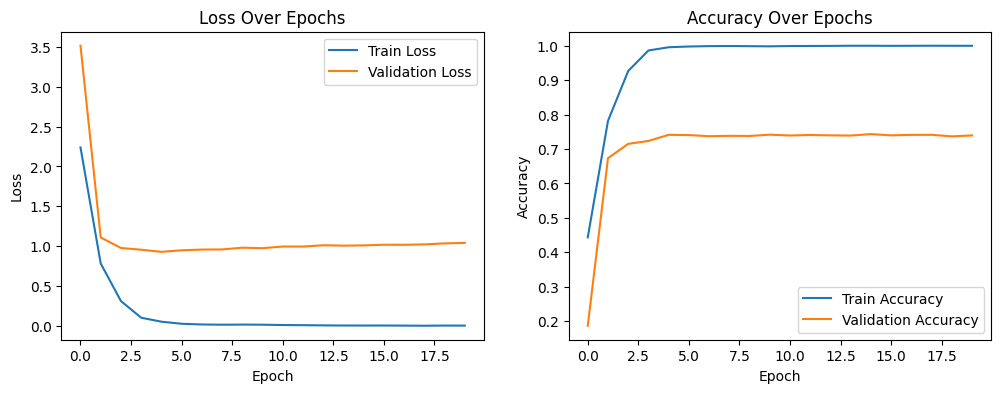

In [35]:
history_graph.plot_history(history_resnet50_no_aug)


# 훈련 로스, 정확도 비교 

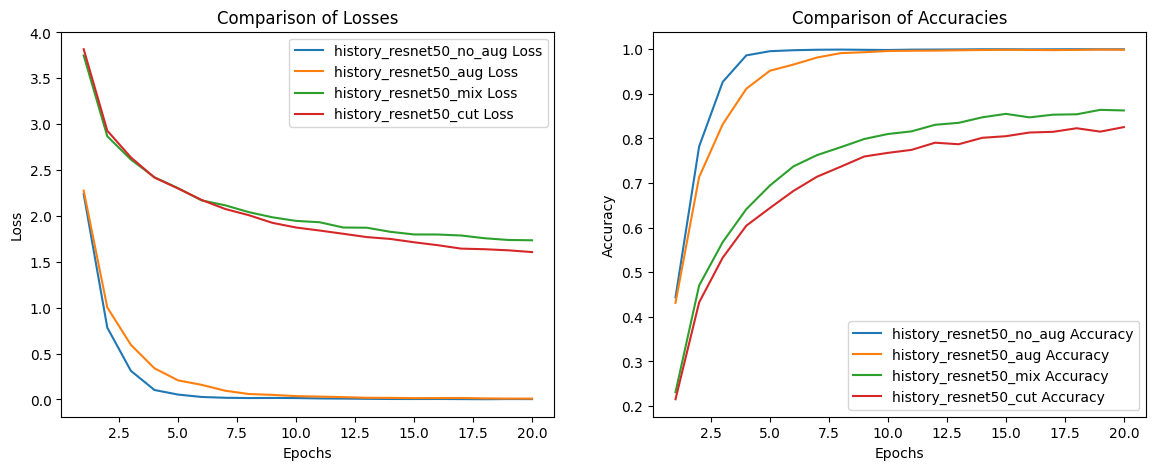

In [36]:
import matplotlib.pyplot as plt

# 예시 데이터
# 각 history 객체의 손실 및 정확도 값
loss1 = history_resnet50_no_aug.history['loss']
accuracy1 = history_resnet50_no_aug.history['accuracy']
loss2 = history_resnet50_aug.history['loss']
accuracy2 = history_resnet50_aug.history['accuracy']
loss3 = history_resnet50_mix.history['loss']
accuracy3 = history_resnet50_mix.history['accuracy']
loss4 = history_resnet50_cut.history['loss']
accuracy4 = history_resnet50_cut.history['accuracy']

epochs = range(1, len(loss1) + 1)

# 손실 그래프
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss1, label='history_resnet50_no_aug Loss')
plt.plot(epochs, loss2, label='history_resnet50_aug Loss')
plt.plot(epochs, loss3, label='history_resnet50_mix Loss')
plt.plot(epochs, loss4, label='history_resnet50_cut Loss')
plt.title('Comparison of Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy1, label='history_resnet50_no_aug Accuracy')
plt.plot(epochs, accuracy2, label='history_resnet50_aug Accuracy')
plt.plot(epochs, accuracy3, label='history_resnet50_mix Accuracy')
plt.plot(epochs, accuracy4, label='history_resnet50_cut Accuracy')
plt.title('Comparison of Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# 검증 로스, 정확도 비교 

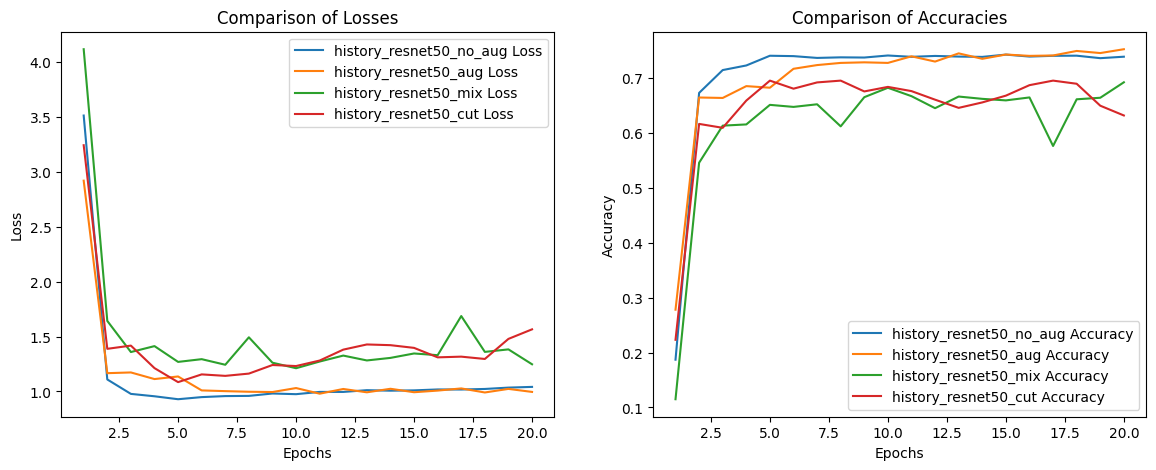

In [37]:
import matplotlib.pyplot as plt

# 예시 데이터
# 각 history 객체의 손실 및 정확도 값
loss1 = history_resnet50_no_aug.history['val_loss']
accuracy1 = history_resnet50_no_aug.history['val_accuracy']
loss2 = history_resnet50_aug.history['val_loss']
accuracy2 = history_resnet50_aug.history['val_accuracy']
loss3 = history_resnet50_mix.history['val_loss']
accuracy3 = history_resnet50_mix.history['val_accuracy']
loss4 = history_resnet50_cut.history['val_loss']
accuracy4 = history_resnet50_cut.history['val_accuracy']

epochs = range(1, len(loss1) + 1)

# 손실 그래프
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss1, label='history_resnet50_no_aug Loss')
plt.plot(epochs, loss2, label='history_resnet50_aug Loss')
plt.plot(epochs, loss3, label='history_resnet50_mix Loss')
plt.plot(epochs, loss4, label='history_resnet50_cut Loss')
plt.title('Comparison of Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy1, label='history_resnet50_no_aug Accuracy')
plt.plot(epochs, accuracy2, label='history_resnet50_aug Accuracy')
plt.plot(epochs, accuracy3, label='history_resnet50_mix Accuracy')
plt.plot(epochs, accuracy4, label='history_resnet50_cut Accuracy')
plt.title('Comparison of Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
